A notebook analyzing all the ITL sensors in the etraveler. A scoring algorithm is developed and applied at the bottom.

It appears there is a problem with how the noise is being pulled out of etraveler, so we'll keep it out of the metric for now and just check the top performers by hand.

In [1]:
# this is the partner code that can run anywhere using the pickled data, produced by script at SLAC
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
import datetime
import collections
import numpy as np
import argparse
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import scipy as sc
import scipy.signal
import textwrap
import pylab

# this magic command makes plots appear within the notebook
%matplotlib inline

# define figure size parameters to make figures larger than default
figwidth=30
figheight=10

In [2]:
import pickle
# I ran rank_ITLnew.py at SLAC, then pickled the data. 
f=open('ITLnewdump.p','rb')
expDict=pickle.load(f)
ccd_list=pickle.load(f)
bias_dic=pickle.load(f, encoding='latin1')
RTM_dic=pickle.load(f)
f.close()

In [3]:
def get_CTI(d, ccd):

        cti_low_serial = []
        cti_high_serial = []
        cti_low_parallel = []
        cti_high_parallel = []

        for amp in d['cte'][ccd]['steps']['cte_offline']['cte'][1:]:
            cti_low_serial.append(amp['cti_low_serial'])
            cti_high_serial.append(amp['cti_high_serial'])
            cti_low_parallel.append(amp['cti_low_parallel'])
            cti_high_parallel.append(amp['cti_high_parallel'])

        ctils=np.array(cti_low_serial)
        ctihs=np.array(cti_high_serial)
        ctilp=np.array(cti_low_parallel)
        ctihp=np.array(cti_high_parallel)

        print(ccd,'\n sum serial low:', ctils.sum(), 
              '\n sum serial high:', ctihs.sum(), 
              '\n worst serial low:', max(cti_low_serial), 
              '\n worst serial high:', max(cti_high_serial),
              '\n worst parallel low:', max(cti_low_parallel), 
              '\n worst parallel high:', max(cti_high_parallel), '\n', '\n')

        return np.array(cti_low_serial), np.array(cti_high_serial), np.array(cti_low_parallel), np.array(cti_high_parallel)

In [4]:
def get_readnoise(d, ccd):

        read_noise = []

        for amp in d['readnoise'][ccd]['steps']['read_noise_offline']['read_noise'][1:]:
            read_noise.append(amp['read_noise'])

        return np.array(read_noise)

In [5]:
def get_nonlinearity(d, ccd):

        nonlinearity = []

        for amp in d['nonlinearity'][ccd]['steps']['flat_pairs_offline']['flat_pairs'][1:]:
            nonlinearity.append(amp['max_frac_dev'])

        return np.array(nonlinearity)

In [6]:
def defectsFraction(d, ccd, col_len=2000, totPixels=1024000.0):
        #sum defect types and express as fraction (per segment)
        # totPixels = 1025024 E2V, 1024000 ITL

        amps = []
        numBrightPixels = []
        numBrightColumns = []
        numDarkPixels = []
        numDarkColumns = []
        numTraps = []

        for amp in d['brightdefects'][ccd]['steps']['bright_defects_offline']['bright_defects']:
            numBrightPixels.append(amp['bright_pixels'])
            numBrightColumns.append(amp['bright_columns'])

        for amp in d['darkdefects'][ccd]['steps']['dark_defects_offline']['dark_defects']:
            numDarkPixels.append(amp['dark_pixels'])
            numDarkColumns.append(amp['dark_columns'])

        for amp in d['traps'][ccd]['steps']['traps_offline']['traps']:
            numTraps.append(amp['num_traps'])

        numBrightPixels = np.array(numBrightPixels[1:])
        numBrightColumns = np.array(numBrightColumns[1:])
        numDarkPixels = np.array(numDarkPixels[1:])
        numDarkColumns = np.array(numDarkColumns[1:])
        numTraps = np.array(numTraps[1:])

        return ((numBrightPixels+numDarkPixels+numTraps+col_len*(numBrightColumns + numDarkColumns))/totPixels), numBrightColumns

In [7]:
def metric(ccd_list, expDict, bias_dic, RTM_dic):
        ccd_dic={}
        for ccd in ccd_list:
            defectsfrac, nbcs = defectsFraction(expDict,ccd)
            nbc=nbcs.sum()

            ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd)
            ctemax=max(ctils.max(),ctihs.max())
            rn = get_readnoise(expDict,ccd)

            bias = bias_dic[ccd]
            RTM = RTM_dic[ccd]
            nonlinearity = get_nonlinearity(expDict, ccd)

            # Score = sCTI/2 + defects/0.2% + nonlinearity/1% + Bias/5000
            Score = ctemax/2.e-6 + defectsfrac.mean()/0.002 + max(nonlinearity)/.01 + bias/5000
            #Scorenew = (ctils.sum()+ctihs.sum())/20.e-6 + defectsfrac.mean()/0.002 + nonlinearity.mean()/.01 + bias/5000
            ctterm= (ctils.sum()+ctihs.sum())/40.e-6 + (ctils.max()+ctihs.max())/20.e-6
            defterm= defectsfrac.mean()/0.002
            nlterm=nonlinearity.mean()/.01
            bterm=bias/2000

# there appears to be a problem with how the noise is gathered...looks as if Richard
# is getting the system noise, not the read noise, so we'll leave this off for now,
# and we'll have to check by hand.

            noiseterm=0.
            #print(rn,'\n')
            for noise in np.nditer(rn):
                if (noise>9.):
                    noiseterm+=(noise-9.)/16.
            #print(noiseterm)
            
            Scorenew=ctterm+defterm+nlterm+bterm
        
            ccd_dic[ccd] = [Score,Scorenew,ctterm,defterm,nlterm,bterm, RTM]
            df = pd.DataFrame(ccd_dic).transpose()
            df.columns = ['OldScore', 'Score', 'CtiScore', 'DefectScore','NonlinScore','BiasScore', 'RTM']
            df = df.astype(dtype= {"OldScore":"float64",
                    "Score":"float64","CtiScore":"float64", "DefectScore":"float64","NonlinScore":"float64",
                                   "BiasScore":"float64","RTM":"object"})


        return df

In [8]:
df =metric(ccd_list, expDict, bias_dic, RTM_dic)
df.RTM=df['RTM'].str[-3:]
df.RTM = pd.to_numeric(df.RTM)
#print (df['RTM'])
#print(df.sort_values(by='Score'))
#df.str.len(df['RTM'])
#x= df['RTM']
#print(x)
#len(x)


ITL-3800C-411 
 sum serial low: 2.78812373438e-05 
 sum serial high: 1.29647511926e-05 
 worst serial low: 2.9478230771928793e-06 
 worst serial high: 9.982592246160493e-07 
 worst parallel low: 4.952337349095615e-07 
 worst parallel high: 6.488102144430741e-07 
 

ITL-3800C-509 
 sum serial low: 4.32535499044e-05 
 sum serial high: 3.28264035261e-05 
 worst serial low: 4.789519607584225e-06 
 worst serial high: 4.6643513087474275e-06 
 worst parallel low: 3.220625615085737e-07 
 worst parallel high: 4.2695994295627315e-08 
 

ITL-3800C-262 
 sum serial low: 4.68090521508e-05 
 sum serial high: 4.54095295481e-05 
 worst serial low: 9.158088687399868e-06 
 worst serial high: 9.044792932400014e-06 
 worst parallel low: 2.812558648201957e-07 
 worst parallel high: 2.2559733281468652e-07 
 

ITL-3800C-161 
 sum serial low: 1.04145909035e-05 
 sum serial high: 5.15249596162e-05 
 worst serial low: 2.8536028366943356e-06 
 worst serial high: 1.654324478295166e-05 
 worst parallel low: 4.2392

 worst serial low: 2.322492582607083e-05 
 worst serial high: 6.604490863537649e-06 
 worst parallel low: 2.319780776360858e-07 
 worst parallel high: 6.327784518589397e-08 
 

ITL-3800C-338 
 sum serial low: 4.65134008891e-05 
 sum serial high: 4.38448229261e-05 
 worst serial low: 1.1421905583119951e-05 
 worst serial high: 1.0530250619922299e-05 
 worst parallel low: 1.1972294942097506e-06 
 worst parallel high: 1.1331070481901406e-06 
 

ITL-3800C-339 
 sum serial low: 5.85194925407e-05 
 sum serial high: 5.92294495618e-05 
 worst serial low: 9.568479981680866e-06 
 worst serial high: 9.691475497675128e-06 
 worst parallel low: 1.2192788290121825e-07 
 worst parallel high: 3.2011932660225284e-08 
 

ITL-3800C-138 
 sum serial low: 2.34195319422e-05 
 sum serial high: 2.38034446056e-05 
 worst serial low: 4.600386091624387e-06 
 worst serial high: 4.605597041518195e-06 
 worst parallel low: 1.2694059137174918e-07 
 worst parallel high: 6.959222531577325e-08 
 

ITL-3800C-208 
 sum s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114f74da0>]], dtype=object)

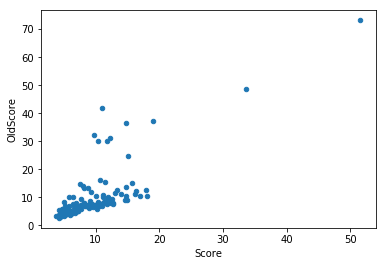

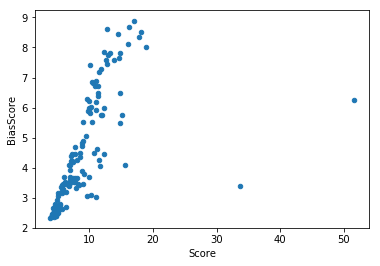

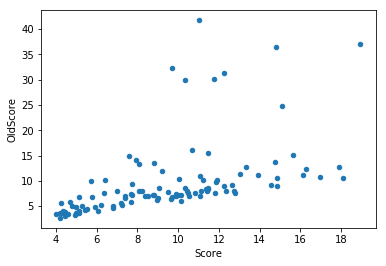

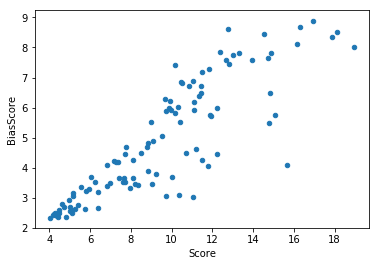

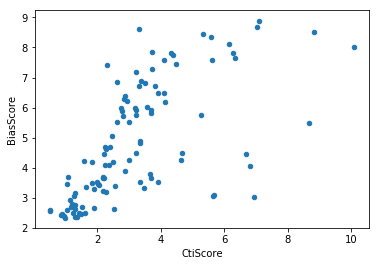

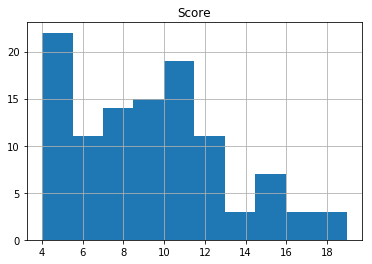

In [9]:
df.plot.scatter(x='Score',y='OldScore')
df.plot.scatter(x='Score',y='BiasScore')
z=df[(df.Score <= 20 ) & (np.isnan(df.RTM))] # select ones not shown to be on rafts in etraveler
#print (z['RTM'])
z.plot.scatter(x='Score',y='OldScore')
z.plot.scatter(x='Score',y='BiasScore')
z.plot.scatter(x='CtiScore',y='BiasScore')
z.hist(column='Score')
#plt.scatter(x, y, 80,'b','^',label='', alpha=0.65)
#print (z['Score'])
#print(z)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
#print(z.sort_values(by='Score'))
z1=z[['Score','BiasScore','CtiScore', 'DefectScore', 'NonlinScore']]
pd.set_option('display.max_rows',200)
round(z1.nsmallest(70,'Score'),2)

,Score,BiasScore,CtiScore,DefectScore,NonlinScore
ITL-3800C-076,4.02,2.34,1.00,0.01,0.68
ITL-3800C-470,4.19,2.41,0.89,0.00,0.88
ITL-3800C-502,4.22,2.47,0.89,0.01,0.85
ITL-3800C-478,4.27,2.49,1.42,0.07,0.30
ITL-3800C-480,4.31,2.44,0.84,0.07,0.96
ITL-3800C-019,4.36,2.40,0.96,0.00,1.00
ITL-3800C-140,4.37,2.47,1.47,0.00,0.42
ITL-3800C-419,4.43,2.35,1.35,0.13,0.60
ITL-3800C-355,4.45,2.59,1.06,0.00,0.79
ITL-3800C-040,4.46,2.50,1.25,0.01,0.70


and we can easily export any of this to an excel file, if you want it.